In [3]:
import os
from pathlib import Path
from typing import Tuple

import numpy as np
import xarray as xr
from xgboost import XGBRegressor

from gradboost_pv.models.utils import NWP_FPATH, GSP_FPATH
from gradboost_pv.models.utils import load_nwp_coordinates
from gradboost_pv.inference.data_feeds import MockDataFeed
from gradboost_pv.inference.models import (
    NationalBoostInferenceModel,
    NationalPVModelConfig,
    Hour,
)
from gradboost_pv.inference.run import (
    MockDatabaseConnection,
    NationalBoostModelInference,
)

In [7]:
MOCK_DATE_RANGE = slice(
    np.datetime64("2020-08-02T00:00:00"), np.datetime64("2020-08-04T00:00:00")
)
DEFAULT_PATH_TO_MOCK_DATABASE = (
    Path(os.path.abspath('')) / "data" / "mock_inference_database.p"
)

def load_model_from_local(forecast_hour_ahead: Hour) -> XGBRegressor:
    _model = XGBRegressor()
    _model.load_model(
        f"/home/tom/dev/gradboost_pv/data/uk_region_model_step_{forecast_hour_ahead}.model"
    )
    return _model


def load_nwp() -> xr.Dataset:
    return xr.open_zarr(NWP_FPATH)


def load_gsp() -> xr.Dataset:
    return xr.open_zarr(GSP_FPATH).sel(gsp_id=0)


def create_date_range_slice(
    nwp: xr.Dataset,
    gsp: xr.Dataset,
    datetime_range: slice = MOCK_DATE_RANGE,
) -> Tuple[xr.Dataset, xr.Dataset]:
    return nwp.sel(init_time=datetime_range), gsp.sel(datetime_gmt=datetime_range)


In [8]:
# load data to feed into mock data feed
nwp, gsp = load_nwp(), load_gsp()
nwp, gsp = create_date_range_slice(nwp, gsp)

data_feed = MockDataFeed(nwp, gsp)
data_feed.initialise()

# load in our national pv model
x, y = load_nwp_coordinates()
config = NationalPVModelConfig(
    "mock_inference",
    overwrite_read_datetime_at_inference=False,
    time_variable_name="init_time",
    nwp_variable_name="variable",
    x_coord_name="x",
    y_coord_name="y",
    gsp_time_variable_name="datetime_gmt",
    gsp_pv_generation_name="generation_mw",
    gsp_installed_capacity_name="installedcapacity_mwp",
)
model = NationalBoostInferenceModel(
    config, load_model_from_local, nwp.coords["x"].values, nwp.coords["y"].values
)
model.initialise()

# create a mock database to write to
database_conn = MockDatabaseConnection(DEFAULT_PATH_TO_MOCK_DATABASE, overwrite_database=True)

inference_pipeline = NationalBoostModelInference(model, data_feed, database_conn)
inference_pipeline.run()

In [9]:
# open database
database_conn = MockDatabaseConnection(DEFAULT_PATH_TO_MOCK_DATABASE, overwrite_database=False)
database_conn.connect()

# view 'database'
database_conn.database.data


,datetime_of_target_utc,forecast_kw
2020-08-03,2020-08-03 00:00:00,0.0
2020-08-03,2020-08-03 01:00:00,0.0
2020-08-03,2020-08-03 02:00:00,0.0
2020-08-03,2020-08-03 03:00:00,0.0
2020-08-03,2020-08-03 04:00:00,0.0
...,...,...
2020-08-04,2020-08-05 08:00:00,2149.598523
2020-08-04,2020-08-05 09:00:00,3558.569091
2020-08-04,2020-08-05 10:00:00,4421.373287
2020-08-04,2020-08-05 11:00:00,5298.033692


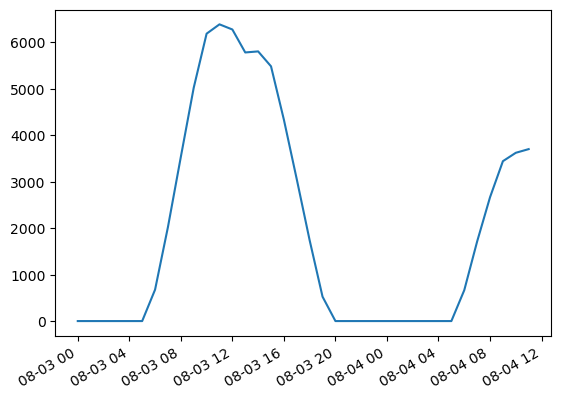

In [14]:
import matplotlib.pyplot as plt

_slice = database_conn.database.data.iloc[:36]

fig, ax = plt.subplots(1,1)

ax.plot(_slice["datetime_of_target_utc"], _slice["forecast_kw"])
fig.autofmt_xdate()
plt.show()